In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract

pytesseract.pytesseract.tesseract_cmd=R'C:/Program Files/Tesseract-OCR/tesseract'

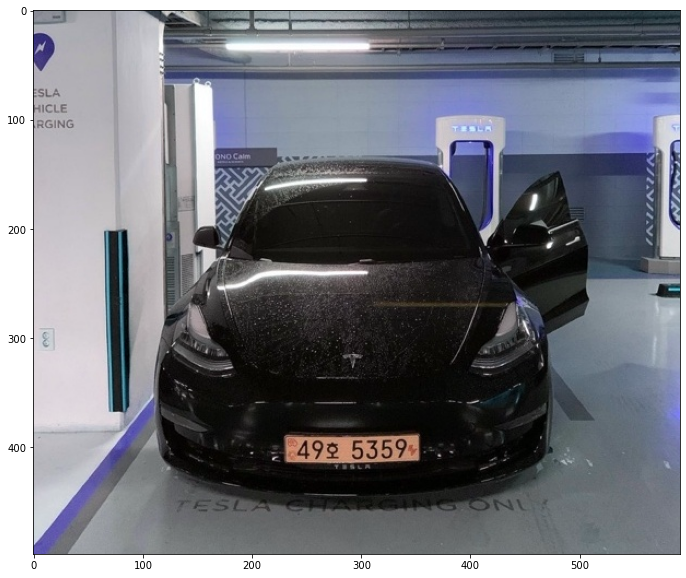

In [2]:
#input image를 읽는다.
img_ori = cv2.imread('4.jpg') #3.jpg랑 4.jpg만 가능

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

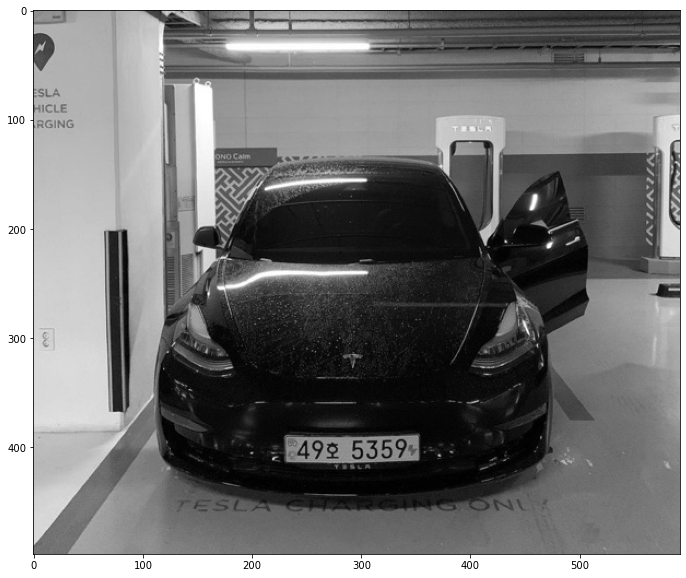

In [3]:
# 이미지를 grayscale로 바꾼다.
hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

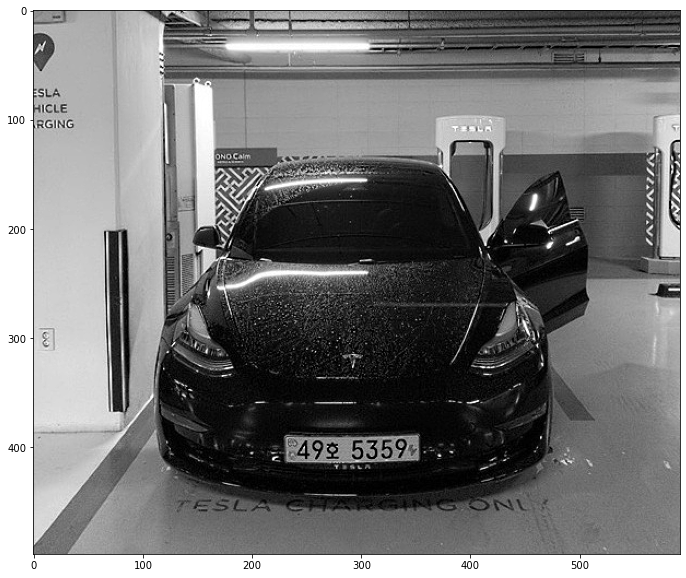

In [4]:
#maximize contrast(optional)

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

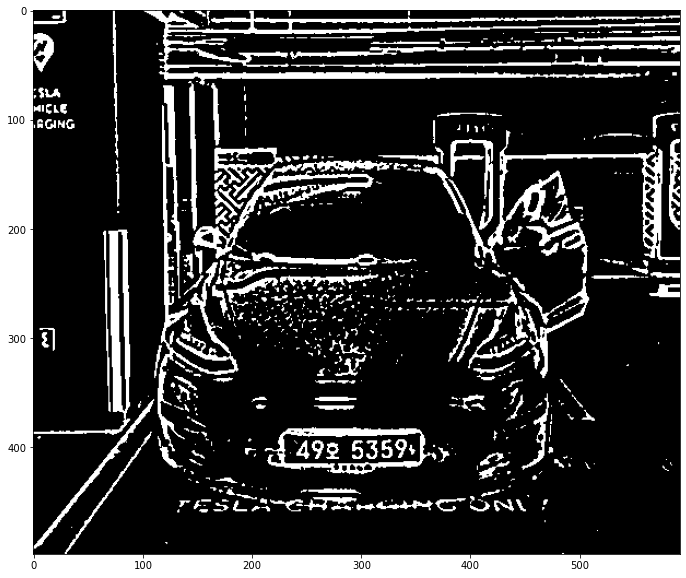

In [5]:
#adaptive thresholding

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) #노이즈 제거

img_thresh = cv2.adaptiveThreshold( #검은색과 흰색으로 이미지를 구분해서 나눔(번호판 찾기 쉽게)
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

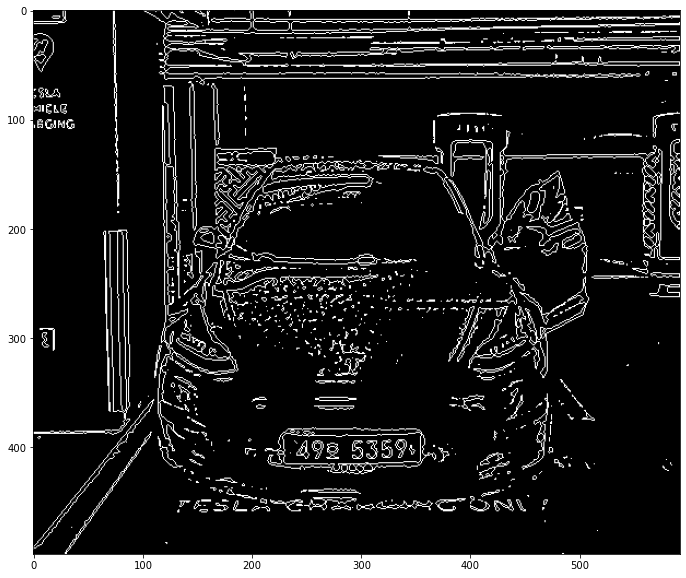

In [6]:
#find contours
contours, _ = cv2.findContours( #윤곽선 찾기
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255)) #윤곽선을 그린다

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

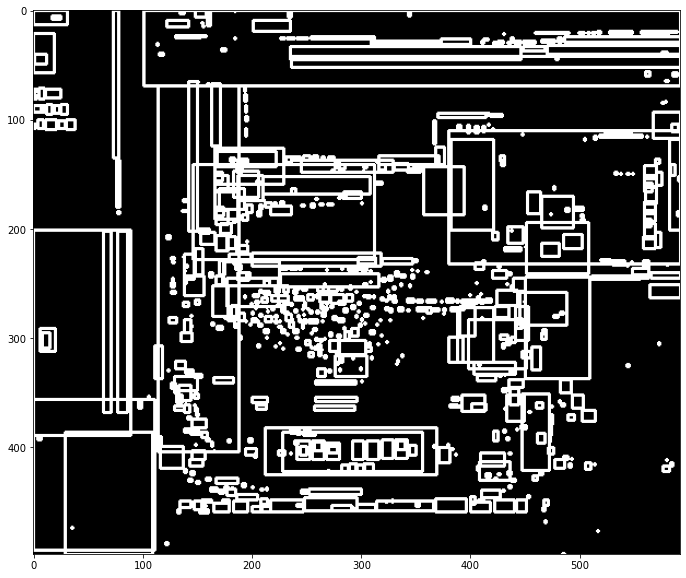

In [7]:
#prepare data
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) #윤곽선을 감싸는 사각형을 구한다
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2) #사각형 그리는 함수
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2), #사각형의 중심좌표
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

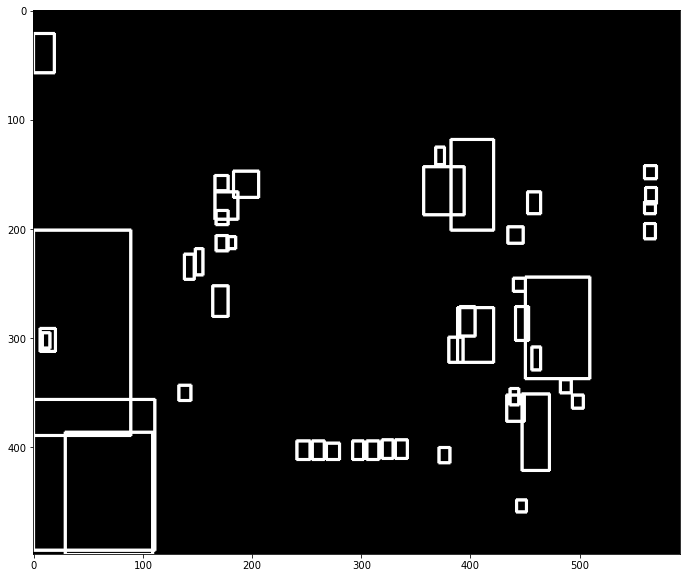

In [8]:
#select candidates by char size
#번호판의 넓이를 어느정도 가정
MIN_AREA = 80 #번호판 숫자의 윤곽선의 사각형의 최소 넓이는 80
MIN_WIDTH, MIN_HEIGHT = 2, 8 #최소 넓이와 넢이
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h'] #넓이
    ratio = d['w'] / d['h'] #비율
    
    #우리가 지정한 조건들에 맞는 애들만 possible contours에 저장
    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt #index를 저장(연산을 위해)
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

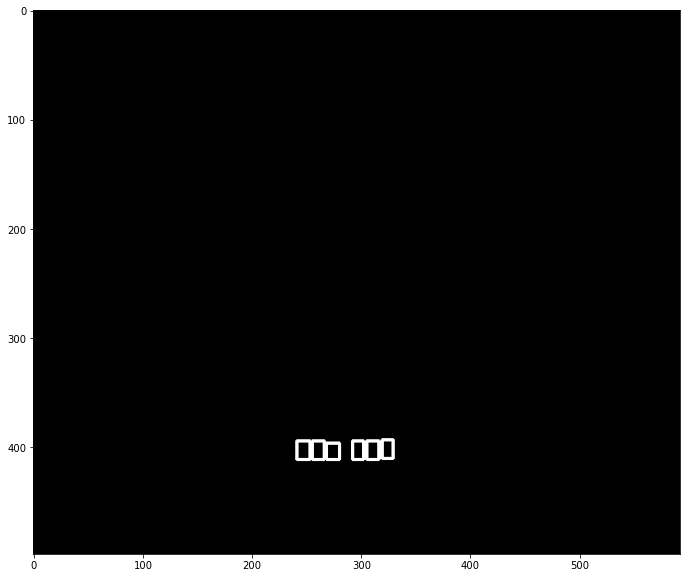

In [9]:
#select candidates by arrangement of contours
# 사각형의 배열의 위치(6개가 보통 붙어있으니까), 면적등을 보면서 번호판에 더 가까운 윤곽선만 고른다
MAX_DIAG_MULTIPLYER = 3 # 5 첫번째 contour의 대각선길이의 5배안에 있어야 한다고 가정
MAX_ANGLE_DIFF = 12.0 # 12.0 첫번째 contour랑 두번쨰 contour의 중심을 이었을때 세타 값의 최대값을 준다
MAX_AREA_DIFF = 0.5 # 0.5 면적의 차이가 너무나지않게
MAX_WIDTH_DIFF = 0.5 #자체 너비가 차이가 너무 나지 않게
MAX_HEIGHT_DIFF = 0.2 #높이
MIN_N_MATCHED = 3 # 3 번호판인거 같은애들을 뽑았는데 3개미만이면 번호판이 아니구 3개이상이어야 번호판

def find_chars(contour_list): #재귀함수로 반복해서 번호판 찾기위해 함수로 지정
    matched_result_idx = [] #최종 index값 저장
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']: #같은 index면 같은거니까 비교하지 않도록 한다.
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])) #contour사이의 거리
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) #radian값을 각도로 바꿔준다.
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) #면적으 ㅣ비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] #넓이의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] #높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED: #후보군의 길이가 3보다 작으면 번호판에서 제외 시킴
            continue

        matched_result_idx.append(matched_contours_idx) #최종 후보군

        unmatched_contour_idx = [] #최종후보군이 아닌애들도 다시한번 비교해본다
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour) #재귀함수에 넣어서 다시 돌려본다
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx) #돌렸을때 다시 맞다고 하는 애들을 최종 후보군에 다시 넣어준다

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

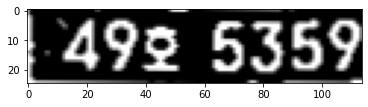

In [10]:
#rotate plate images 살짝 기울어진 이미지를 조정해준다.
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 2
MAX_PLATE_RATIO = 8

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    #번호판 부분만 잘라주는것
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    #plt.imshow(img_cropped,cmap='gray') #번호판 자른것만 나온다.
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped,cmap='gray')

4호535


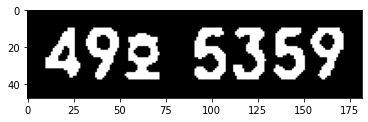

In [11]:
#another thresholding to find chars
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs): #한번더 contour 찾아서 기준에 맞는지 번호판이 맞는지 확인하는것.
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x] #tessseract 하기전에 최종 작업(노이즈한번더제거..등)
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    #이미지에서 string 뽑아낸다. psm은 글자가 한줄로 있다. oem 0은 가장 옛날 엔진을 쓰겠다.(번호판인식과 잘맞음)
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0') 
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit(): #글자랑 숫자가 있는지 확인
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

4호535


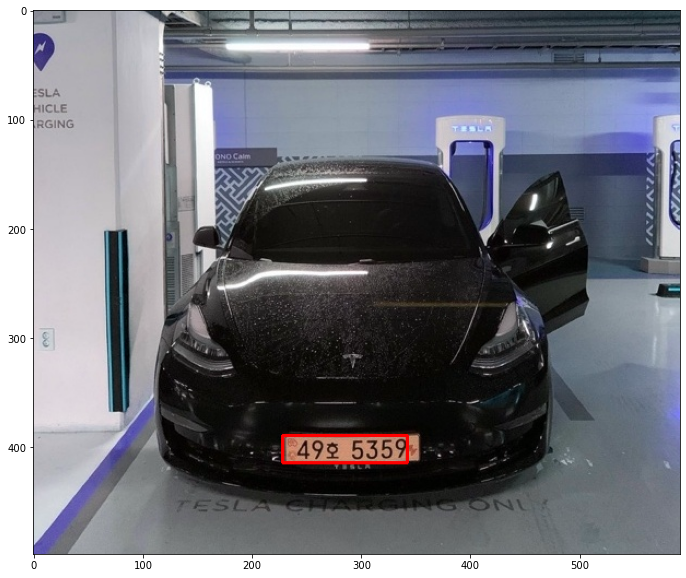

In [12]:
#result
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)

In [13]:
# 이미지를 자른다 -> 번호판만 잘라옴
x1=info['x']
x2=info['x']+info['w']
y1=info['y']
y2=info['y']+info['h']

src = cv2.imread('4.jpg')
dst = src[y1:y2, x1:x2].copy() #높이,넓이

# cv2.imshow('source', src)
# cv2.imshow('cut image', dst)
cv2.imwrite('new.png',dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
#잘라온 번호판으로 mask처리
src = cv2.imread('new.png')
hsv= cv2.cvtColor(src,cv2.COLOR_BGR2HSV)

lower = np.array([43,43,117])
upper = np.array([211,220,254])

mask = cv2.inRange(hsv,lower,upper)
# cv2.imshow('src', src)
# cv2.imshow('hsv', hsv)
# cv2.imshow('mask',mask)

cv2.waitKey()
cv2.destroyAllWindows()

In [15]:
#전기차인지 아닌지 본격 판정
isElectronic = 0 
notElectronic = 0
height = src.shape[0]
width = src.shape[1]

for y in range(height):
    for x in range(width):
        if mask[y, x] >= 1: # 픽셀 값이 1 이상이면 전기차로 가정
            isElectronic += 1
        else:
            notElectronic += 1
                                  
print(isElectronic, notElectronic)
            
if 10 * isElectronic >= notElectronic: # 10배(하이퍼 파라미터) 이상 차이가 나면 전기자동차로 인식
    print("전기 자동차가 검출되었습니다.")

else:
    print("전기 자동차가 아닙니다.")

2084 766
전기 자동차가 검출되었습니다.
